In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('cs-training.csv', index_col = 0)
df.head()
df.info()
df.isnull().sum()
df['SeriousDlqin2yrs'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [4]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())

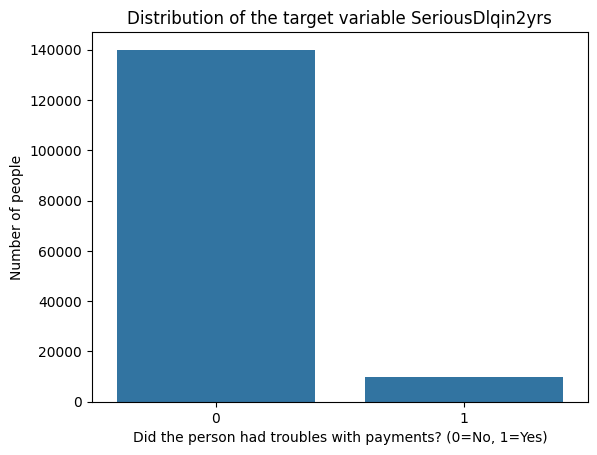

In [5]:
df['SeriousDlqin2yrs'].value_counts()
sns.countplot(x='SeriousDlqin2yrs', data=df)
plt.title('Distribution of the target variable SeriousDlqin2yrs')
plt.xlabel('Did the person had troubles with payments? (0=No, 1=Yes)')
plt.ylabel('Number of people')
plt.show()

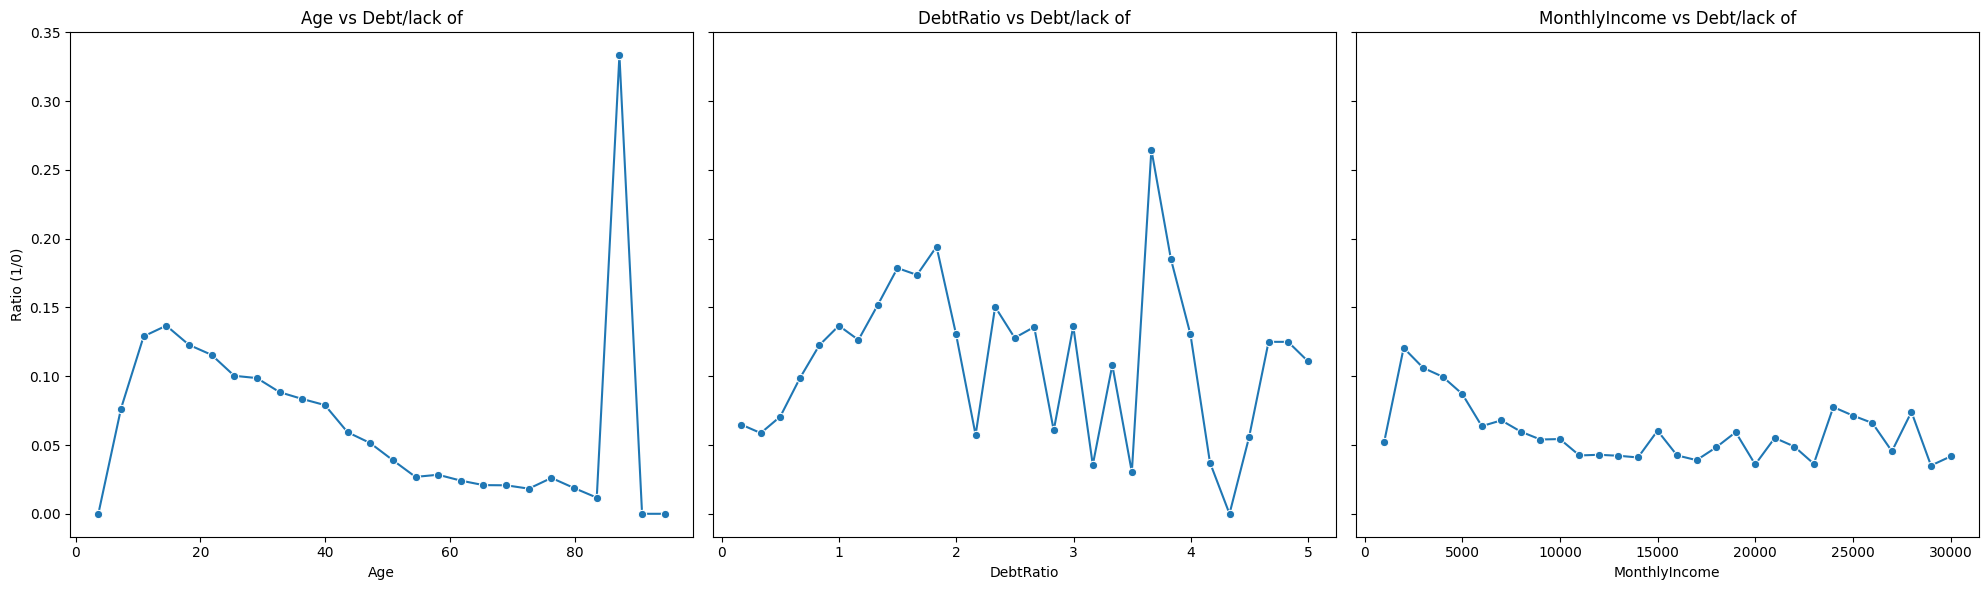

In [6]:
def get_ratio_data(feature, max_val=None, bins=30):
    data = df.copy()
    if max_val is not None:
        data = data[data[feature] < max_val]

    bins_edges = np.linspace(data[feature].min(), data[feature].max(), bins + 1)
    data[f'{feature}_bin'] = pd.cut(data[feature], bins=bins_edges, include_lowest=True)

    grouped = data.groupby([f'{feature}_bin', 'SeriousDlqin2yrs'], observed=True).size().unstack(fill_value=0)

    grouped['ratio'] = grouped.get(1, 0) / grouped.get(0, 1).replace(0, np.nan)
    grouped = grouped.dropna(subset=['ratio'])

    bin_right_edges = bins_edges[1:len(grouped)+1]

    return bin_right_edges, grouped['ratio']

age_x, age_y = get_ratio_data('age')
debt_x, debt_y = get_ratio_data('DebtRatio', max_val=5)
income_x, income_y = get_ratio_data('MonthlyIncome', max_val=30000)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

sns.lineplot(x=age_x, y=age_y, marker='o', ax=axes[0])
axes[0].set_title('Age vs Debt/lack of')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Ratio (1/0)')

sns.lineplot(x=debt_x, y=debt_y, marker='o', ax=axes[1])
axes[1].set_title('DebtRatio vs Debt/lack of')
axes[1].set_xlabel('DebtRatio')

sns.lineplot(x=income_x, y=income_y, marker='o', ax=axes[2])
axes[2].set_title('MonthlyIncome vs Debt/lack of')
axes[2].set_xlabel('MonthlyIncome')

plt.tight_layout()
plt.show()

In [7]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#logistic regression
model = LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

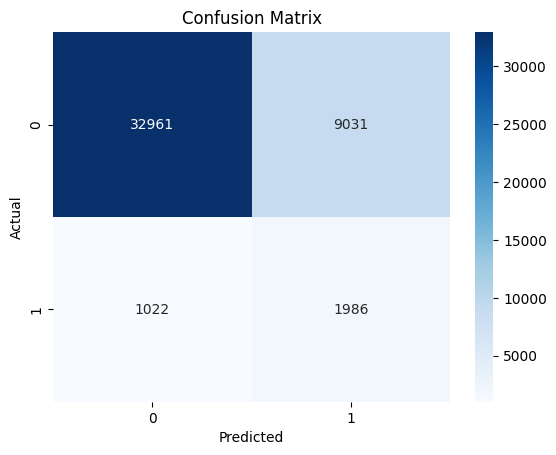

In [10]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
#random forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]

In [12]:
#XGBoost
xgb = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
xgb_proba = xgb.predict_proba(X_test_scaled)[:, 1]

In [13]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     41992
           1       0.18      0.66      0.28      3008

    accuracy                           0.78     45000
   macro avg       0.58      0.72      0.58     45000
weighted avg       0.92      0.78      0.83     45000

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.56      0.15      0.24      3008

    accuracy                           0.94     45000
   macro avg       0.75      0.57      0.60     45000
weighted avg       0.92      0.94      0.92     45000

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     41992
           1       0.23      0.70      0.35      3008

    accuracy                           0.83     45000
   macro avg     

In [19]:
acc_log = round(accuracy_score(y_test, y_pred), 3)
rec_log = round(recall_score(y_test, y_pred), 3)
auc_log = round(roc_auc_score(y_test, y_proba), 3)

acc_rf = round(accuracy_score(y_test, rf_pred), 3)
rec_rf = round(recall_score(y_test, rf_pred), 3)
auc_rf = round(roc_auc_score(y_test, rf_proba), 3)

acc_xgb = round(accuracy_score(y_test, xgb_pred), 3)
rec_xgb = round(recall_score(y_test, xgb_pred), 3)
auc_xgb = round(roc_auc_score(y_test, xgb_proba), 3)

results = [
    ["Logistic Regression", acc_log, rec_log, auc_log],
    ["Random Forest", acc_rf, rec_rf, auc_rf],
    ["XGBoost", acc_xgb, rec_xgb, auc_xgb]
]

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Recall (class 1)", "ROC AUC"])
results_df

,Model,Accuracy,Recall (class 1),ROC AUC
0,Logistic Regression,0.777,0.660,0.800
1,Random Forest,0.935,0.151,0.837
2,XGBoost,0.825,0.697,0.845


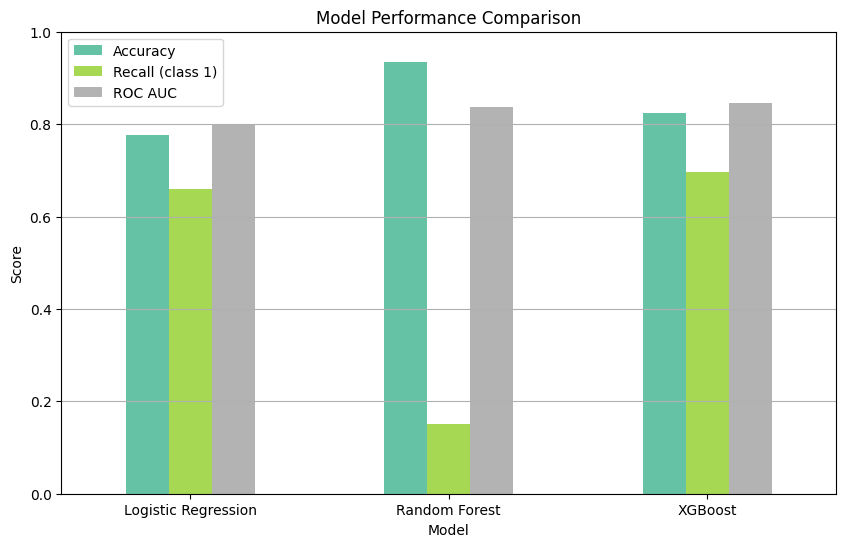

In [20]:
results_df.set_index("Model")[["Accuracy", "Recall (class 1)", "ROC AUC"]].plot(
    kind="bar", figsize=(10, 6), colormap="Set2"
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [22]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_proba)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_proba)

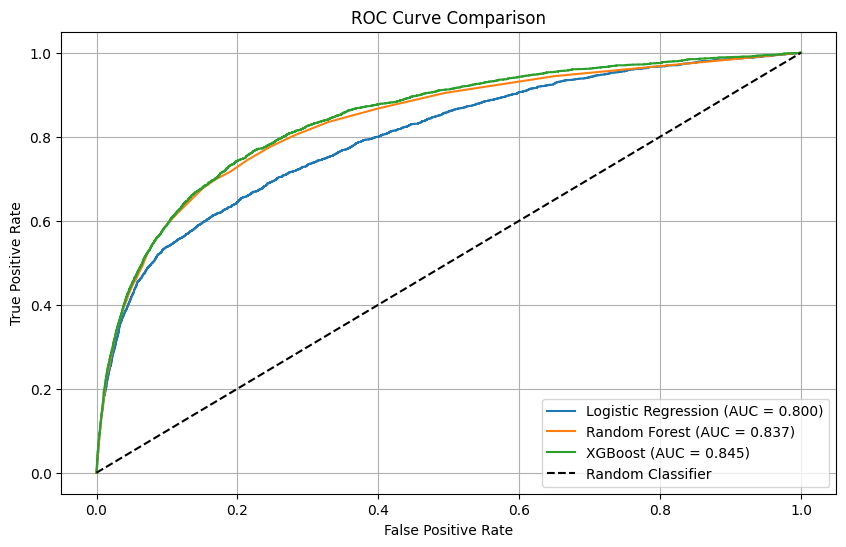

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Project Summary

The goal of this project was to build a predictive model to assess whether a customer is likely to experience a serious delinquency (90+ days late) within the next two years (`SeriousDlqin2yrs`), based on demographic and financial information.

#### Steps of the analysis:
1. **Data Exploration:** Missing values were identified in the `MonthlyIncome` and `NumberOfDependents` columns and filled using the median.
2. **Visualization:** The distributions of key features such as `age`, `DebtRatio`, and `MonthlyIncome` were analyzed in relation to the target variable. Distinct patterns were observed between delinquent and non-delinquent customers.
3. **Data Preparation:** The dataset was split into training and test sets, and features were standardized using `StandardScaler`.
4. **Modeling:** Comparing multiple classification models including Logistic Regression, Random Forest, and XGBoost.
5. **Model Evaluation:** Assessing model performance using metrics such as Accuracy, ROC-AUC, and confusion matrices.
6. **Insights:** Identifying the best-performing model and drawing business-relevant conclusions for credit risk prediction.